#Import

In [ ]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
# import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


# Activation Function

In [ ]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

class Max(nn.Module):
    def forward(self, x):

        return torch.max(torch.zeros_like(x), x**3)

# 사용 예시
activation = torch.tanh
activation_ = torch.tanh

#Build Network

In [ ]:
M = 32
selu = Swish()

T = True
F = False

class Net_Torsion(nn.Module):
    def __init__(self):
        super(Net_Torsion, self).__init__()
        # torch.manual_seed(1234) # Fix Initial_Parameter
        self.hidden_layer1 = nn.Linear(1,M, bias = T)
        # torch.manual_seed(1234)
        self.hidden_layer2 = nn.Linear(M,M, bias = T)
        # torch.manual_seed(1234)
        # self.hidden_layer3 = nn.Linear(M,M, bias = T)
        # torch.manual_seed(1234)
        # self.hidden_layer4 = nn.Linear(M,M, bias = T)
        # torch.manual_seed(1234)
        self.output_layer = nn.Linear(M,1, bias = T)
#
    def forward(self, x):
        inputs = torch.cat([x],axis=1)
        layer1_out = activation_(self.hidden_layer1(inputs))
        layer2_out = activation_(self.hidden_layer2(layer1_out))
        # layer3_out = activation_(self.hidden_layer3(layer2_out))
        # layer4_out = activation_(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer2_out)

        return output

#set PDE,residual

In [ ]:
L = 1

N = 1 ## variable scaling factor

r_0 = 1
t = 0.2
G = 1
T_ = 1

M = 150

# 반지름 함수
def r(x):
    return 1 + 1/(1+torch.exp(-(M)*(x/N - 0.5)))

#반지름 함수 미분
def dr(x):
    return (r_0*M/N)*(torch.exp(-M*(x/N - 0.5)))/((1+torch.exp(-(M)*(x/N - 0.5)))**2)

# J(x)
def J(x):
    return ((r(x))**4-(r(x)-t)**4)

# J(x) 미분
def dJ(x):
    return dr(x)*4*((r(x))**3-(r(x)-t)**3)

In [ ]:
def f(x, net):
    u = net(x)

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    pde = 1*(N*N*dJ(x)*u_x + N*N*J(x)*u_xx)/(N*N)

    return pde


## Compute Solution

In [ ]:
def r_np(x):
    return 1 + 1/(1+np.exp(-(M)*x + 0.5*M))

def dr_np(x):
    return (1*M)*(np.exp(-M*x + 0.5*M))/((1+np.exp(-(M)*x + 0.5*M))**2)


def J_np(x):
    return (np.pi/32)*((r_np(x))**4-(r_np(x)-0.2)**4)

In [ ]:
sol = []
tmp = 0

for i in range(1,10001):
    tmp = tmp + (1)*(1/J_np(0.0001*i))*0.0001
    sol.append(tmp)

In [ ]:
Solution = torch.tensor(sol).view(10000,1).to(device)

# Boundary Condition

In [ ]:
X = np.ones((1,1))*(1)*N
pt_X = Variable(torch.from_numpy(X).float(), requires_grad = False).to(device)

In [ ]:
print(0.5*pt_X)
print(dr(0.5*pt_X))
print(J(1*pt_X))
print(dJ(0.5*pt_X))

tensor([[0.5000]], device='cuda:0')
tensor([[37.5000]], device='cuda:0')
tensor([[5.5024]], device='cuda:0')
tensor([[176.7000]], device='cuda:0')


In [ ]:
H = 1

du_dx = (H*T_ / (G*torch.pi / 32 * J(pt_X))) /N
du_dx.required_grad = False

du_dx
print(du_dx)

##------------------------------Boundary data point-------------------------------------------##

x_0 = np.zeros((1,1))
x_N = np.ones((1,1))*(1)*N

##---------------------------------Condition Label--------------------------------##

u_x0 =  np.zeros((1,1))

##--------------------------------------------------------------------------##

C_x_0 = Variable(torch.from_numpy(x_0).float(), requires_grad=True).to(device)
C_x_N = Variable(torch.from_numpy(x_N).float(), requires_grad=True).to(device)
pt_u_x0 = Variable(torch.from_numpy(u_x0).float(), requires_grad=False).to(device) ## x=0 경계 조건

tensor([[1.8512]], device='cuda:0')


#Define Diff

In [ ]:
def dx(x, net):
    u = net(x)

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]

    return u_x

#Set Observer Point

In [ ]:
x_D = np.linspace(0 ,1*(1)*N , 10000).reshape(10000,1)

pt_x = Variable(torch.from_numpy(x_D).float(), requires_grad = False).to(device)

pt_x

tensor([[0.0000e+00],
        [1.0001e-04],
        [2.0002e-04],
        ...,
        [9.9980e-01],
        [9.9990e-01],
        [1.0000e+00]], device='cuda:0')

#loss,optimize

In [ ]:
import torch
import torch.nn.init as init

### (2) Model
mse_cost_function = torch.nn.MSELoss() #MSE Function can be shared

net_T = Net_Torsion()
net_T = net_T.to(device)


optimizer = torch.optim.Adam(net_T.parameters(),lr=0.001)

#Train

In [ ]:
x_collocation = np.linspace(0.00*N, (1)*N, 100).reshape(-1,1)
all_zeros = np.zeros((100,1))
pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

In [ ]:
previous_validation_loss = 99999999.0
gap3 = 1
epoch = 0

# for epoch in range(iterations):
# while gap3 > 0.0:
while epoch < 20001:
    optimizer.zero_grad()

##-------------------------------Condition predict output------------------------------------##

    net_x0_out = net_T(C_x_0)
    net_dxN_out = dx(C_x_N, net_T)

##------------------------------------Condition Loss-----------------------------------------##
    mse_x0t = mse_cost_function(net_x0_out, pt_u_x0)
    mse_xNt = mse_cost_function(net_dxN_out, du_dx)


##------------------------------------Compute Loss-----------------------------------------##

    f_out = f(pt_x_collocation, net_T)

    mse_f = mse_cost_function(f_out, pt_all_zeros)
    loss = 10*mse_x0t + 10*mse_xNt + 1*mse_f

##------------------------------------Optimize Loss-----------------------------------------##

    loss.backward()
    optimizer.step()
    epoch += 1

##----------------------------Result-----------------------------##
    if (epoch) % 1000 == 1:

        pt_u3 = net_T(pt_x)


        gap3 = torch.sqrt(((Solution - pt_u3)**2).mean())/torch.sqrt((Solution**2).mean())


        print("-----------------------------------------------------------------------------")
        print("Epoch:",epoch)
        print("Error: ",gap3.item())
        print("Residual1 Loss :", mse_f.item())
        print(loss)

        # iter.append(epoch)
        # loss3.append((loss).cpu().detach().numpy())
        # loss1.append(mse_xNt.item())
        # loss2.append(mse_f.item())

-----------------------------------------------------------------------------
Epoch: 1
Error:  0.022057681391031196
Residual1 Loss : 0.10527122020721436
tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------------------------------------------------------
Epoch: 1001
Error:  0.017139048580371855
Residual1 Loss : 0.6125275492668152
tensor(0.6223, device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------------------------------------------------------
Epoch: 2001
Error:  0.020855040117026425
Residual1 Loss : 0.09177587181329727
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------------------------------------------------------
Epoch: 3001
Error:  0.022236564279419616
Residual1 Loss : 0.16577692329883575
tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------------------------------------------------------
Epoch: 4001
Error:  0.015128199178889523
Residual1 Loss : 0.06755929440259933


#Plotting Prediction

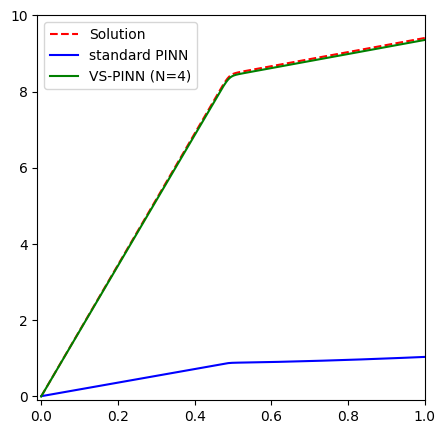

9.353364


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize = (5,5)) #피규어 사이즈
ax = fig.add_subplot()

x=np.linspace(0,1,10000)  #보여줄 x 축 범위

ms_x = np.meshgrid(x)

x = np.ravel(ms_x).reshape(-1,1)

pt_x0 = Variable(torch.from_numpy(x).float(), requires_grad=False).to(device)

pt_u0 = net_T(N*pt_x0)

u = pt_u0.data.cpu().numpy()


ms_u = []

for i in range(len(u)):
  ms_u.append(u[i][0])

ns_u = []

ns_u.append(ms_u)

plt.plot(ms_x[0],sol[0:10000],'r--', label = "Solution")
surf2 = ax.plot(ms_x[0],ns_u1[0],'b',label = "standard PINN")
surf1 = ax.plot(ms_x[0],ns_u[0],'g', label = "VS-PINN (N=4)")

plt.ylim(-0.1, 10)
plt.xlim(-0.01,1)
# plt.yscale('log')

plt.legend(loc = "upper left")

plt.show()

print(u.max())

#Plot Learning Curve

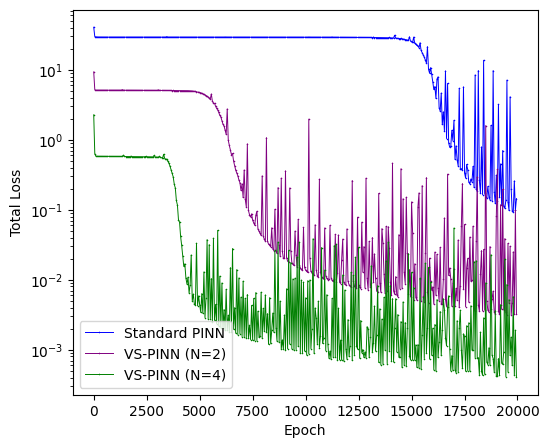

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))


plt.plot(iter, loss1 ,color = 'blue', marker='x',markersize=0.5,label = "Standard PINN",linewidth="0.7")

plt.plot(iter, loss2 ,color = 'purple', marker='x',markersize=0.5,label = "VS-PINN (N=2)",linewidth="0.7")

plt.plot(iter, loss3 ,color = 'green', marker='x',markersize=0.5,label = "VS-PINN (N=4)",linewidth="0.7")


plt.yscale('log')
plt.legend(loc = 'lower left')

plt.xlabel('Epoch')
plt.ylabel('Total Loss')
# plt.ylabel('Relative L2 Error')
plt.show()
plt.close()